In [1]:
# imports
from nibabel.testing import data_path
import numpy as np
import tensorflow as tf
from keras import applications
import nibabel as nib
import keras
import os
import pandas as pd
import re

In [3]:
# enable GPU
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14268218335786896359
xla_global_id: -1
]


In [5]:
# import keras required libs.
import matplotlib.pyplot as plt
import glob
from keras.losses import categorical_crossentropy
from keras.models import Sequential, Model 
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras import layers
from sklearn.model_selection import train_test_split

In [26]:
# bringing in dataframe
df = pd.read_csv('OASIS4_data_clinical.csv')

In [27]:
# Regex
pattern = r"\d{5}"

In [28]:
# fetch the files we need.
filename_list = []
for name in glob.glob('./NIIs only TEST/*.nii.gz'):
    filename_list.append(name)
print(len(filename_list))

149


In [32]:
# Dealing with missing images/ clinical entries
x=0
while x < len(filename_list):
    if "run-01" in filename_list[x] or "run-03" in filename_list[x]:
        os.remove(filename_list[x])
        filename_list.pop(x)
    x+=1
print(len(filename_list))
filename_list=sorted(filename_list)
for i in range(len(filename_list)):
    print(filename_list[i])

132
./NIIs only TEST/sub-OAS42000_sess-d3016_T2w.nii.gz
./NIIs only TEST/sub-OAS42001_sess-d3006_T2w.nii.gz
./NIIs only TEST/sub-OAS42002_sess-d3018_T2w.nii.gz
./NIIs only TEST/sub-OAS42003_sess-d3042_run-02_T2w.nii.gz
./NIIs only TEST/sub-OAS42004_sess-d3015_T2w.nii.gz
./NIIs only TEST/sub-OAS42006_sess-d3084_T2w.nii.gz
./NIIs only TEST/sub-OAS42007_sess-d3492_T2w.nii.gz
./NIIs only TEST/sub-OAS42009_sess-d2904_T2w.nii.gz
./NIIs only TEST/sub-OAS42010_sess-d3091_T2w.nii.gz
./NIIs only TEST/sub-OAS42011_sess-d3023_T2w.nii.gz
./NIIs only TEST/sub-OAS42012_sess-d3019_T2w.nii.gz
./NIIs only TEST/sub-OAS42014_sess-d3055_T2w.nii.gz
./NIIs only TEST/sub-OAS42015_sess-d3169_T2w.nii.gz
./NIIs only TEST/sub-OAS42016_sess-d3005_T2w.nii.gz
./NIIs only TEST/sub-OAS42017_sess-d3009_T2w.nii.gz
./NIIs only TEST/sub-OAS42019_sess-d3017_T2w.nii.gz
./NIIs only TEST/sub-OAS42020_sess-d3036_T2w.nii.gz
./NIIs only TEST/sub-OAS42022_sess-d3015_T2w.nii.gz
./NIIs only TEST/sub-OAS42023_sess-d3055_T2w.nii.gz
.

In [33]:
x=0
while x < len(filename_list):
    match = re.search(pattern, filename_list[x])
    file_num = match.group(0)
    match = re.search(pattern, df['oasis_id'][x])
    clinical_num = match.group(0)
    print(file_num, clinical_num)
    if (int(file_num) < int(clinical_num)):
        os.remove(filename_list[x])
        filename_list.pop(x)
    elif (int(file_num) > int(clinical_num)):
        df = df.drop(labels=x, axis=0)
        df = df.reset_index(drop=True)
    x+=1
print(x)

42000 42000
42001 42001
42002 42002
42003 42003
42004 42004
42006 42006
42007 42007
42009 42009
42010 42010
42011 42011
42012 42012
42014 42013
42015 42015
42016 42016
42017 42017
42019 42019
42020 42020
42022 42022
42023 42023
42024 42024
42025 42025
42026 42026
42027 42027
42028 42028
42029 42029
42030 42030
42032 42032
42033 42033
42034 42034
42035 42035
42036 42036
42037 42037
42038 42038
42040 42040
42041 42041
42042 42042
42043 42043
42044 42044
42045 42045
42046 42046
42047 42047
42048 42048
42049 42049
42050 42050
42051 42051
42052 42052
42053 42053
42054 42054
42055 42055
42056 42056
42057 42057
42058 42058
42059 42059
42060 42060
42061 42061
42062 42062
42063 42063
42064 42064
42065 42065
42066 42066
42067 42067
42068 42068
42069 42069
42070 42070
42071 42071
42072 42072
42073 42073
42074 42074
42075 42075
42077 42077
42078 42078
42079 42079
42080 42080
42082 42082
42083 42083
42084 42084
42085 42085
42086 42086
42087 42087
42089 42089
42090 42090
42091 42091
42092 42092
4209

In [34]:
# test if worked. if it prints anything then it didnt work.
for x in range(len(filename_list)):
    if df['oasis_id'][x] in filename_list[x]:
        continue
    else:
        print(x)
        print(df['oasis_id'][x])
        print(filename_list[x])
        break

In [35]:
# Cutting the tail values we don't need and making a
# column of the corresponding images.
df = df.iloc[:-(df.shape[0]-len(filename_list))] 
df['image_path'] = filename_list
df.shape[0]
df.tail()

,oasis_id,demographics_id,demographics_firstvisit,sex,age,edu,race,hispanic,marriage,declong,...,health_history4,health_history5,health_history6,health_history7,health_history10,health_history11,health_history12,final_dx,final_dx_categorized,image_path
126,OAS42146,OAS42146_demographics_d3000,0,1,77,0,1,0,1,5.0,...,0,0,0,0,0,0,0,Vascular Cognitive Impairment (VCI),6,./NIIs only TEST/sub-OAS42146_sess-d3504_T2w.n...
127,OAS42147,OAS42147_demographics_d3000,0,1,84,3,1,0,2,1.0,...,0,0,0,0,0,0,0,MCI,2,./NIIs only TEST/sub-OAS42147_sess-d2762_T2w.n...
128,OAS42148,OAS42148_demographics_d3000,0,2,63,2,1,0,1,2.0,...,0,0,0,0,0,0,0,Early Onset AD,4,./NIIs only TEST/sub-OAS42148_sess-d3022_T2w.n...
129,OAS42149,OAS42149_demographics_d3000,0,1,58,0,1,0,1,6.0,...,1,0,0,1,0,0,0,Non-Neurodegenerative Neurologic Disease,5,./NIIs only TEST/sub-OAS42149_sess-d3028_T2w.n...
130,OAS42150,OAS42150_demographics_d3000,0,1,74,4,1,0,1,1.0,...,0,0,0,0,0,0,0,MCI,2,./NIIs only TEST/sub-OAS42150_sess-d3009_T2w.n...


In [36]:
dx_keep = [0,1,2]
for i in range(df.shape[0]-1):
    if df['final_dx_categorized'][i] not in dx_keep:
        df = df.drop(labels=i, axis=0)
df = df.reset_index(drop=True)
df.head(25)

,oasis_id,demographics_id,demographics_firstvisit,sex,age,edu,race,hispanic,marriage,declong,...,health_history4,health_history5,health_history6,health_history7,health_history10,health_history11,health_history12,final_dx,final_dx_categorized,image_path
0,OAS42003,OAS42003_demographics_d3000,0,2,80,2,1,0,3,2.0,...,0,0,0,0,0,0,0,Alzheimer Disease Dementia,1,./NIIs only TEST/sub-OAS42003_sess-d3042_run-0...
1,OAS42004,OAS42004_demographics_d3000,0,2,77,2,1,0,1,5.0,...,0,0,0,0,0,0,0,Alzheimer Disease Dementia,1,./NIIs only TEST/sub-OAS42004_sess-d3015_T2w.n...
2,OAS42006,OAS42006_demographics_d3000,0,2,73,2,1,0,1,5.0,...,0,0,0,0,0,0,0,Alzheimer Disease Dementia,1,./NIIs only TEST/sub-OAS42006_sess-d3084_T2w.n...
3,OAS42007,OAS42007_demographics_d3000,1,1,74,0,1,0,1,3.0,...,0,0,0,0,0,0,1,MCI,2,./NIIs only TEST/sub-OAS42007_sess-d3492_T2w.n...
4,OAS42010,OAS42010_demographics_d3000,1,2,71,2,1,0,3,7.0,...,0,0,0,0,0,0,1,Alzheimer Disease Dementia,1,./NIIs only TEST/sub-OAS42010_sess-d3091_T2w.n...
5,OAS42020,OAS42020_demographics_d3000,0,1,79,2,1,0,1,3.0,...,0,0,0,0,0,0,0,Alzheimer Disease Dementia,1,./NIIs only TEST/sub-OAS42020_sess-d3036_T2w.n...
6,OAS42022,OAS42022_demographics_d3000,0,2,83,2,1,0,1,1.0,...,0,0,0,0,0,0,0,Alzheimer Disease Dementia,1,./NIIs only TEST/sub-OAS42022_sess-d3015_T2w.n...
7,OAS42025,OAS42025_demographics_d3000,0,2,82,1,1,0,3,5.0,...,0,0,0,0,0,0,0,Alzheimer Disease Dementia,1,./NIIs only TEST/sub-OAS42025_sess-d3018_T2w.n...
8,OAS42026,OAS42026_demographics_d3000,0,1,73,4,1,0,4,1.0,...,0,0,0,0,0,0,0,Alzheimer Disease Dementia,1,./NIIs only TEST/sub-OAS42026_sess-d2855_T2w.n...
9,OAS42027,OAS42027_demographics_d3000,0,2,64,4,1,0,1,3.0,...,0,0,0,0,0,0,0,Cognitively Normal,0,./NIIs only TEST/sub-OAS42027_sess-d3034_run-0...


In [37]:
# Label the images
cn_x = []
cn_y = []
ad_x = []
ad_y = []
mci_x = []
mci_y = []
total_data_x = []
total_data_y = []
for i in range(df.shape[0]):
    if df['final_dx_categorized'][i] == 0:
        newimg = nib.load(df['image_path'][i])
        data = newimg.get_fdata()
        if data.shape==(320,320,28):
            cn_x.append(data)
            cn_y.append(0)
    elif df['final_dx_categorized'][i] == 1:
        newimg = nib.load(df['image_path'][i])
        data = newimg.get_fdata()
        if data.shape==(320,320,28):
            ad_x.append(data)
            ad_y.append(1)
    elif df['final_dx_categorized'][i] == 2:
        newimg = nib.load(df['image_path'][i])
        data = newimg.get_fdata()
        if data.shape==(320,320,28):
            mci_x.append(data)
            mci_y.append(2)
for i in range(len(cn_x)):
    total_data_x.append(cn_x[i])
    total_data_y.append(cn_y[i])
for i in range(len(ad_x)):
    total_data_x.append(ad_x[i])
    total_data_y.append(ad_y[i])
for i in range(len(mci_x)):
    total_data_x.append(mci_x[i])
    total_data_y.append(mci_y[i])
print(len(total_data_x))

31


In [38]:
newdata=np.array(total_data_x, dtype=object)
print(type(newdata))
print(newdata.shape)
zeros_array = np.zeros((31, 320, 320, 4))
newdata = np.concatenate((newdata, zeros_array), axis=3)
print(newdata.shape)
maindata=np.stack([newdata]*3, axis=-1)
maindata=maindata.reshape(len(total_data_x)*320,320,32,3)

<class 'numpy.ndarray'>
(31, 320, 320, 28)
(31, 320, 320, 32)


In [40]:
new_y=[]
for i in range (len(total_data_x)):
    for j in range(320):
        new_y.append(total_data_y[i])
new_y=np.array(new_y)

In [41]:
maindata.shape,new_y.shape

((9920, 320, 32, 3), (9920,))

In [42]:
# splitting data for train and test 70:30.
X_train, X_test, y_train, y_test = train_test_split(maindata, new_y, test_size=0.33)
X_train=np.array(X_train)
y_train=np.array(y_train)
x_train = X_train.reshape(X_train.shape[0], 320, 32, 3)

input_shape = (320,32,3)
x_train = x_train.astype('float32')
y_train = keras.utils.to_categorical(y_train)
y_old_test=y_test
y_test = keras.utils.to_categorical(y_test)


In [43]:
# Using ResNet50

model = applications.ResNet50(weights = "imagenet", include_top=False, input_shape=input_shape)


# Freeze the layers which you don't want to train. Here I am not freezing any layer.
for layer in model.layers:
    layer.trainable = True
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation="softmax")(x)
model= Model(model.input, predictions)

94765736/94765736 [==============================] - 2s 0us/step


In [44]:
# Compile and Train:
model.compile(keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
val=model.fit(x=x_train,y=y_train,batch_size=64, epochs=10,validation_split=0.1)

Epoch 1/10
94/94 [==============================] - 174s 2s/step - loss: 1.3727 - accuracy: 0.5855 - val_loss: 1.0059 - val_accuracy: 0.6526
Epoch 2/10
94/94 [==============================] - 185s 2s/step - loss: 0.7943 - accuracy: 0.7044 - val_loss: 0.8905 - val_accuracy: 0.6496
Epoch 3/10
94/94 [==============================] - 188s 2s/step - loss: 0.6027 - accuracy: 0.7571 - val_loss: 0.7436 - val_accuracy: 0.6767
Epoch 4/10
94/94 [==============================] - 194s 2s/step - loss: 0.4819 - accuracy: 0.8059 - val_loss: 0.6060 - val_accuracy: 0.7609
Epoch 5/10
94/94 [==============================] - 186s 2s/step - loss: 0.4075 - accuracy: 0.8365 - val_loss: 0.4984 - val_accuracy: 0.7985
Epoch 6/10
94/94 [==============================] - 191s 2s/step - loss: 0.3460 - accuracy: 0.8621 - val_loss: 0.4795 - val_accuracy: 0.8120
Epoch 7/10
94/94 [==============================] - 188s 2s/step - loss: 0.2896 - accuracy: 0.8885 - val_loss: 0.4228 - val_accuracy: 0.8241
Epoch 8/10
94

In [45]:
X_test=np.array(X_test)
x_test = X_test.reshape(X_test.shape[0],320,32,3)
x_test = x_test.astype('float32')
    # Normalizing the RGB codes by dividing it to the max RGB value.
print('Number of images in x_test', x_test.shape[0])
model.evaluate(x_test,y_test)


Number of images in x_test 3274
103/103 [==============================] - 24s 235ms/step - loss: 0.3640 - accuracy: 0.8604


[0.36400625109672546, 0.8604153990745544]

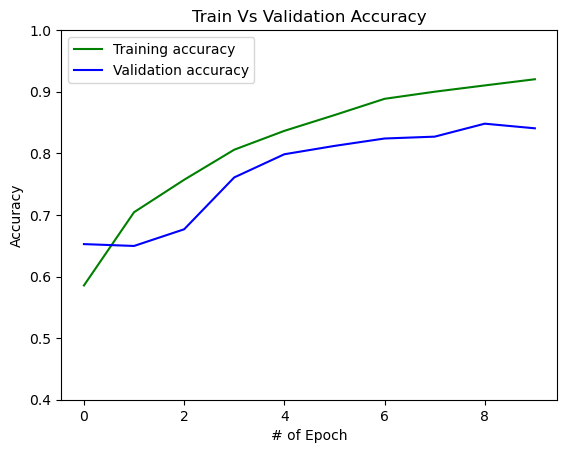

In [46]:
plt.plot(val.history['accuracy'], color='g')
plt.plot(val.history['val_accuracy'], color='b')
plt.legend(['Training accuracy' ,'Validation accuracy'])
plt.title("Train Vs Validation Accuracy")
plt.xlabel("# of Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.40,1)
plt.show()